Data Ingestion

In [1]:
!pip install -qU langchain-text-splitters
!pip install unstructured
!pip install pdfminer.six
!python3 -m pip install pillow-heif

  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
  Using cached python_magic-0.4.27-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached emoji-2.12.1-py3-none-any.whl.metadata (5.4 kB)
  Using cached python_iso639-2024.4.27-py3-none-any.whl.metadata (13 kB)
  Using cached langdetect-1.0.9.tar.gz (981 kB)
  Preparing metadata (setup.py) ... done
  Using cached unstructured_client-0.24.1-py3-none-any.whl.metadata (12 kB)
  Using cached charset_normalizer-3.3.2-cp38-cp38-macosx_11_0_arm64.whl.metadata (33 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached deepdiff-7.0.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached jsonpath_python-1.0.6-py3-none-any.whl.metadata (12 kB)
  Using cached ordered_set-4.1.0-py3-none-any.whl.metadata (5.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.9 MB/s eta 0:00:00a 0:00:01
Using cached emoji-2.12.1-py3-none-any.whl (431 kB)
Using cached filetype-1.2.0-py2.py3-none-any.whl (19 

In [2]:
import os
from typing import List
from langchain.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

from pyprojroot import here
import warnings; warnings.filterwarnings("ignore")
import time

%load_ext autoreload
%autoreload 2

In [3]:
from dotenv import load_dotenv
load_dotenv(dotenv_path=here(".env"))

True

In [4]:
api_key = os.getenv("OPENAI_API_KEY")
if api_key is None:
    raise ValueError("The OPENAI_API_KEY environment variable is not set.")
os.environ["OPENAI_API_KEY"] = api_key

# Setting up Directory Paths, Loading and processing docs

In [5]:

# Replace these with your actual paths
directory_path = here("data/docs")

In [6]:
def load_docs(directory_path):
    """Loads all PDF files from the directory and splits them into chunks."""
    pdf_files = [f for f in os.listdir(directory_path) if f.endswith(".pdf")]
    print("Number of PDF files:", len(pdf_files))
    
    docs = []
    document_file_paths = []  # Initialize the list to store file paths
    
    for pdf_file in pdf_files:
        file_path = os.path.join(directory_path, pdf_file)
        loader = PyPDFLoader(file_path)
        docs.extend(loader.load())
        document_file_paths.append(file_path)  # Add the file path to the list
    
    print("Number of documents:", len(docs))

    return docs, document_file_paths

In [7]:
doc_pages, doc_file_paths =load_docs(directory_path)

Number of PDF files: 1


Number of documents: 97


In [64]:
import matplotlib.pyplot as plt

def split_documentsRCTS(docs: List, chunk_size: int = 1000, chunk_overlap: int = 200):
    """Splits documents into chunks of specified size."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", " ", ""]
    )
    chunked_documents = text_splitter.split_documents(docs)
    len_chunk = []
    for chunk in chunked_documents:
        len_chunk.append(len(chunk.page_content))
    return chunked_documents, len_chunk

def plot_chunks(len_chunk, heading):
    plt.figure(figsize=(10, 5))
    plt.hist(len_chunk, bins=100)
    plt.title(heading)
    
    # Calculate min and max values of len_chunk
    min_len = min(len_chunk)
    max_len = max(len_chunk)
    
    # Define the box properties
    box_props = dict(boxstyle='round', facecolor='yellow', alpha=0.5)
    
    # Add text annotations for min and max values in the top right corner
    plt.text(0.95, 0.95, f'Min: {min_len}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', color='red', bbox=box_props)
    plt.text(0.95, 0.90, f'Max: {max_len}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', color='red', bbox=box_props)
    
    plt.show()

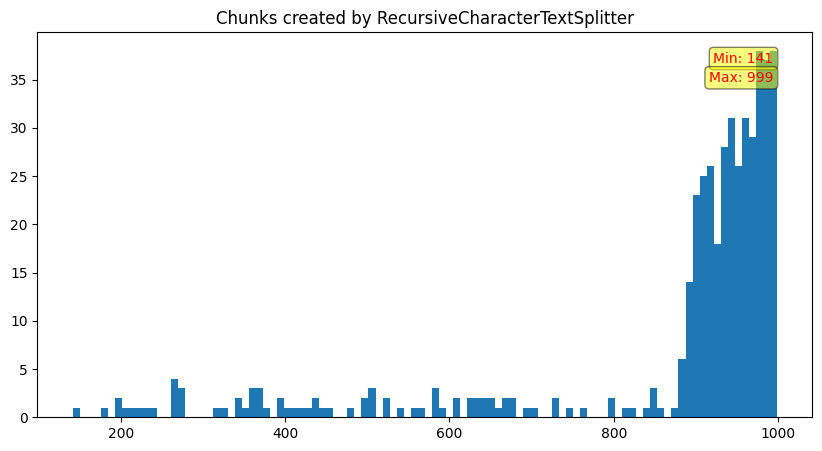

In [65]:
RCTS_chunked_documents, RCTS_len_chunks = split_documentsRCTS(doc_pages, chunk_size=1000, chunk_overlap=200)
plot_chunks(RCTS_len_chunks, "Chunks created by RecursiveCharacterTextSplitter")

## Chunking and Processing data with UNStRCUCTRED.io

- It's able to extract tables, and read within the images in pdf too. 
- It incorporated the OCR features to achieve this feat. For complex and high quality data preparation `unstrcutured.io` can be used. 
- Lets see how Unstructured.io extracts infromation from pdfs. 

In [10]:
!pdfminer.six

zsh:1: command not found: pdfminer.six


In [11]:
doc_file_paths[0]

'/Users/wenda/Documents/github/case_study_financialReport/data/docs/alphabet-2023.pdf'

In [12]:
from unstructured.partition.pdf import partition_pdf
elements = partition_pdf(doc_file_paths[0])

In [22]:
print("Numer of elements formed from the document: ", len(elements))

Numer of elements formed from the document:  4187


In [44]:
elements[100].to_dict()

{'type': 'ListItem',
 'coordinates': ((61.2, 465.85913059999996),
  (61.2, 475.85913059999996),
  (64.7, 475.85913059999996),
  (64.7, 465.85913059999996)),
 'coordinate_system': 'PixelSpace',
 'layout_width': 612.0,
 'layout_height': 792.0,
 'element_id': 'e3b0c44298fc1c149afbf4c8996fb924',
 'metadata': {'filename': 'alphabet-2023.pdf',
  'file_directory': '/Users/wenda/Documents/github/case_study_financialReport/data/docs',
  'filetype': 'application/pdf',
  'page_number': 4},
 'text': ''}

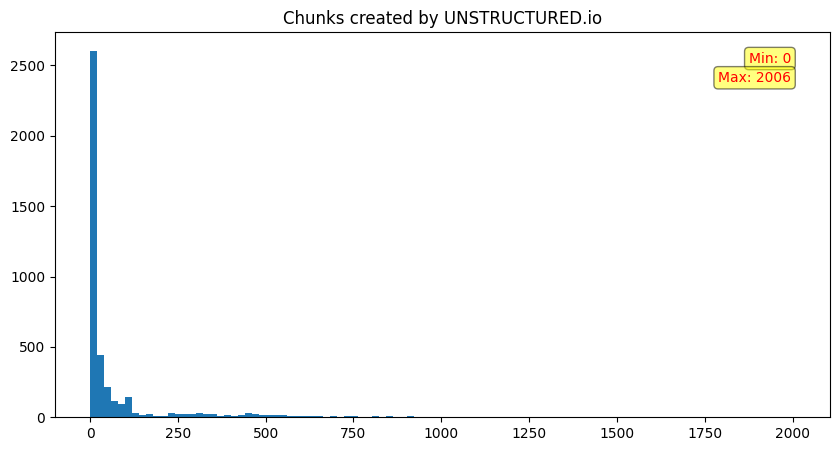

In [66]:
chunk_len = []
for element in elements:
    chunk_len.append(len(str(element)))

plot_chunks(chunk_len, "Chunks created by UNSTRUCTURED.io")

# Embeddings and Vectordb

In [9]:
# 4. Create Chroma Vector Database:
chroma_persist_directory = "chroma/processed_data"  # storing Chroma database
embeddings = OpenAIEmbeddings()
vectordb = Chroma.from_documents(
    documents=documents, 
    embedding=embeddings,
    persist_directory=chroma_persist_directory
)
vectordb.persist()  # Save the database to disk

print("Vector database created successfully!")

/Users/wenda/anaconda3/envs/temus2/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


Vector database created successfully!


/Users/wenda/anaconda3/envs/temus2/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(
